In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Dataset Loading and EDA

In [11]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [12]:
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train Labels: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test Labels: {dict(zip(unique, counts))}")

Train Labels: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test Labels: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


In [3]:
indexes = np.random.randint(0, x_train.shape[0], size=9)
images = x_train[indexes]
labels = y_train[indexes]

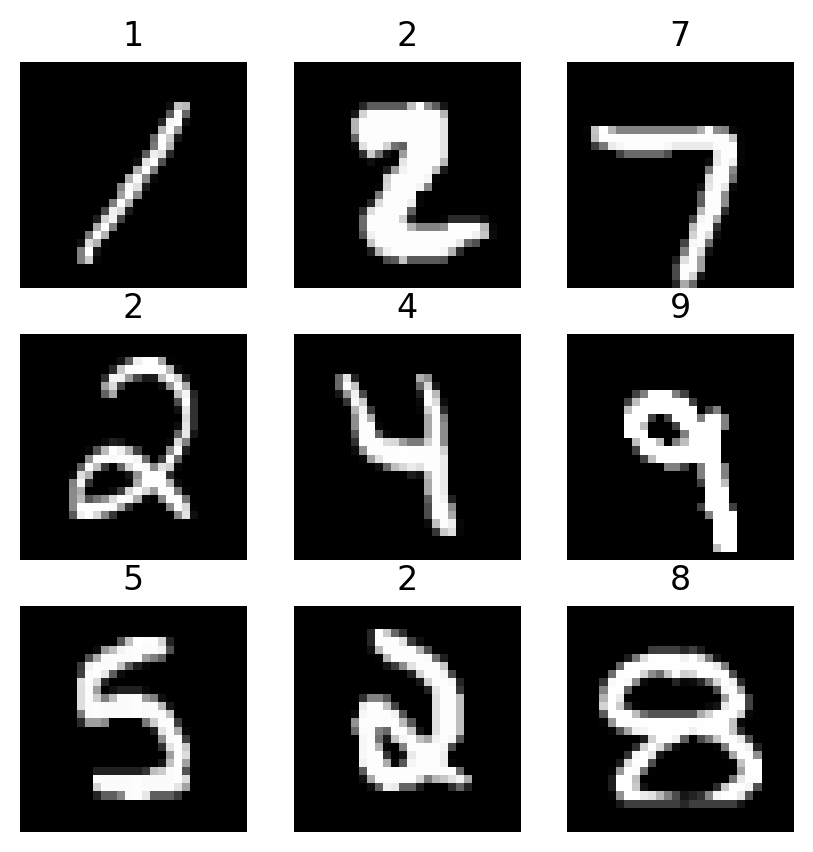

In [4]:
plt.figure(figsize=(5, 5))
for i in range(len(indexes)):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.title(labels[i])
plt.show()

## Preprocessing

In [9]:
num_labels = len(unique)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

x_train = np.reshape(x_train, [-1, x_train.shape[1], x_train.shape[2], 1])
x_test = np.reshape(x_test, [-1, x_test.shape[1], x_test.shape[2], 1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

input_shape = x_train.shape[1:]

## Modeling

### LeNet-5

### Input Shape: 28x28x1(MNIST)
**Convolution Layers**

1. ConV_1 (5x5, s=1, activation='tanh', filters=  6, padding='same')
2. Pooling_2 (f=2, s=2, padding='valid')
3. ConV_3 (5x5, s=1, activation='tanh', filters= 16, padding='valid')
4. Pooling_4 (f=2, s=2, padding='valid')
5. ConV_5 (5x5, s=1, activation='tanh', filters=120, padding='valid')

**Fully Connected Layers**

6. Dense(units=84, activation='tanh')

**Outputs**

7. Dense(units=10, activation='softmax')

In [10]:
from models.LeNet import build_lenet_5, lr_schedule

In [11]:
model = build_lenet_5(input_shape=input_shape)
model.summary()

2023-06-20 14:57:27.783868: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-06-20 14:57:27.783933: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-06-20 14:57:27.783945: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-06-20 14:57:27.784453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-20 14:57:27.784824: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "LeNet_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 14, 14, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         4812

In [39]:
import os

save_dir = os.path.join(os.getcwd(), 'LeNet')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

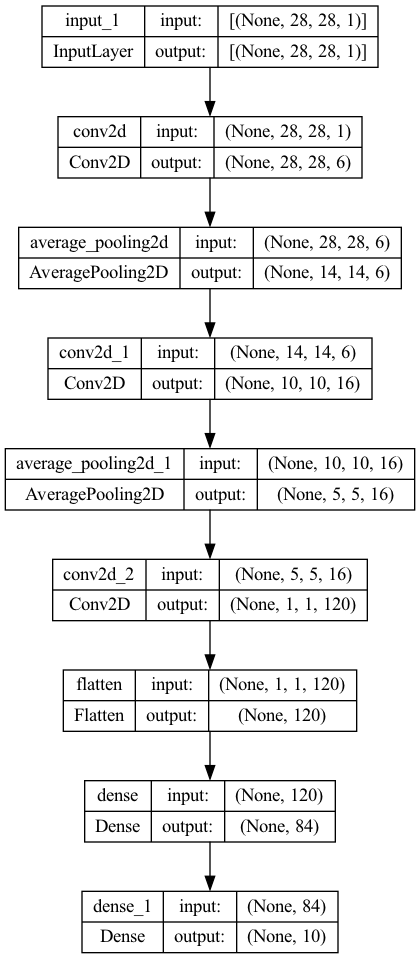

In [14]:
filepath1 = os.path.join(save_dir, 'MNIST_LeNet5.png')

keras.utils.plot_model(model=model,
                       to_file=filepath1,
                       show_shapes=True
                      )

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

model_name = 'mnist_lenet_v5.{epoch:03d}.h5'
filepath2 = os.path.join(save_dir, model_name)

lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoints = ModelCheckpoint(filepath=filepath2,
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True
                             )
callbacks = [checkpoints, lr_scheduler]

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy']
             )

In [16]:
hist = model.fit(x_train, y_train,
                 batch_size=32,
                 epochs=20,
                 validation_data=(x_test, y_test),
                 callbacks=callbacks,
                 verbose=2,
                 shuffle=True
                )

Epoch 1/20


2023-06-20 15:03:55.303474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-20 15:04:10.654524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.57390, saving model to /Users/jaehwan/Desktop/Git/DeepLearning/CV/4. Classic_CNNs/LeNet/mnist_lenet_v5.001.h5
1875/1875 - 17s - loss: 2.2170 - accuracy: 0.3308 - val_loss: 2.0931 - val_accuracy: 0.5739 - lr: 5.0000e-04 - 17s/epoch - 9ms/step
Epoch 2/20


/opt/homebrew/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy improved from 0.57390 to 0.69960, saving model to /Users/jaehwan/Desktop/Git/DeepLearning/CV/4. Classic_CNNs/LeNet/mnist_lenet_v5.002.h5
1875/1875 - 16s - loss: 1.8149 - accuracy: 0.6358 - val_loss: 1.4629 - val_accuracy: 0.6996 - lr: 5.0000e-04 - 16s/epoch - 8ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.69960 to 0.79850, saving model to /Users/jaehwan/Desktop/Git/DeepLearning/CV/4. Classic_CNNs/LeNet/mnist_lenet_v5.003.h5
1875/1875 - 16s - loss: 1.1805 - accuracy: 0.7451 - val_loss: 0.9390 - val_accuracy: 0.7985 - lr: 5.0000e-04 - 16s/epoch - 9ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.79850 to 0.82580, saving model to /Users/jaehwan/Desktop/Git/DeepLearning/CV/4. Classic_CNNs/LeNet/mnist_lenet_v5.004.h5
1875/1875 - 16s - loss: 0.8926 - accuracy: 0.8038 - val_loss: 0.8229 - val_accuracy: 0.8258 - lr: 2.0000e-04 - 16s/epoch - 9ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.82580 to 0.84340, saving model to /Users/jaehwan/Des

In [18]:
loss, acc = model.evaluate(x_test, y_test, batch_size=32)
print(f"Test accuracy: {(100*acc):>.1f}%")

313/313 [==============================] - 2s 6ms/step - loss: 0.6073 - accuracy: 0.8646
Test accuracy: 86.5%


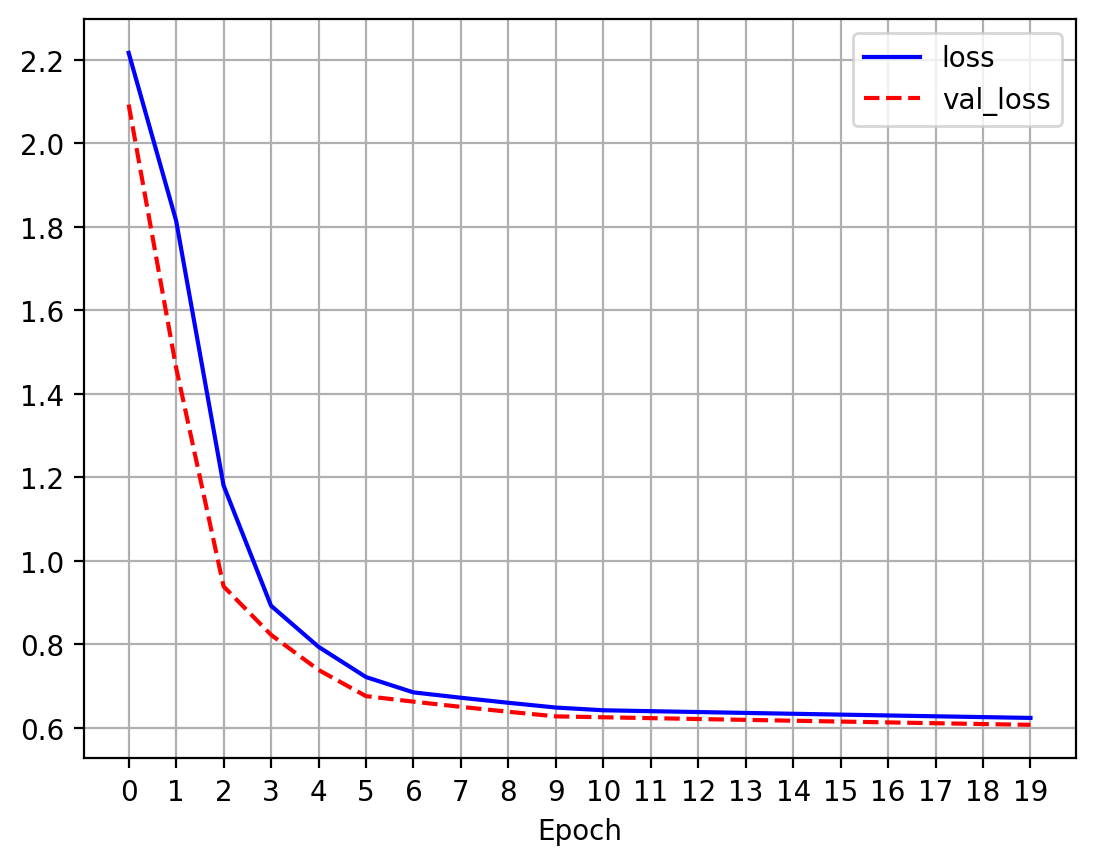

In [19]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.xticks(range(20))
plt.grid()
plt.legend()
plt.show()

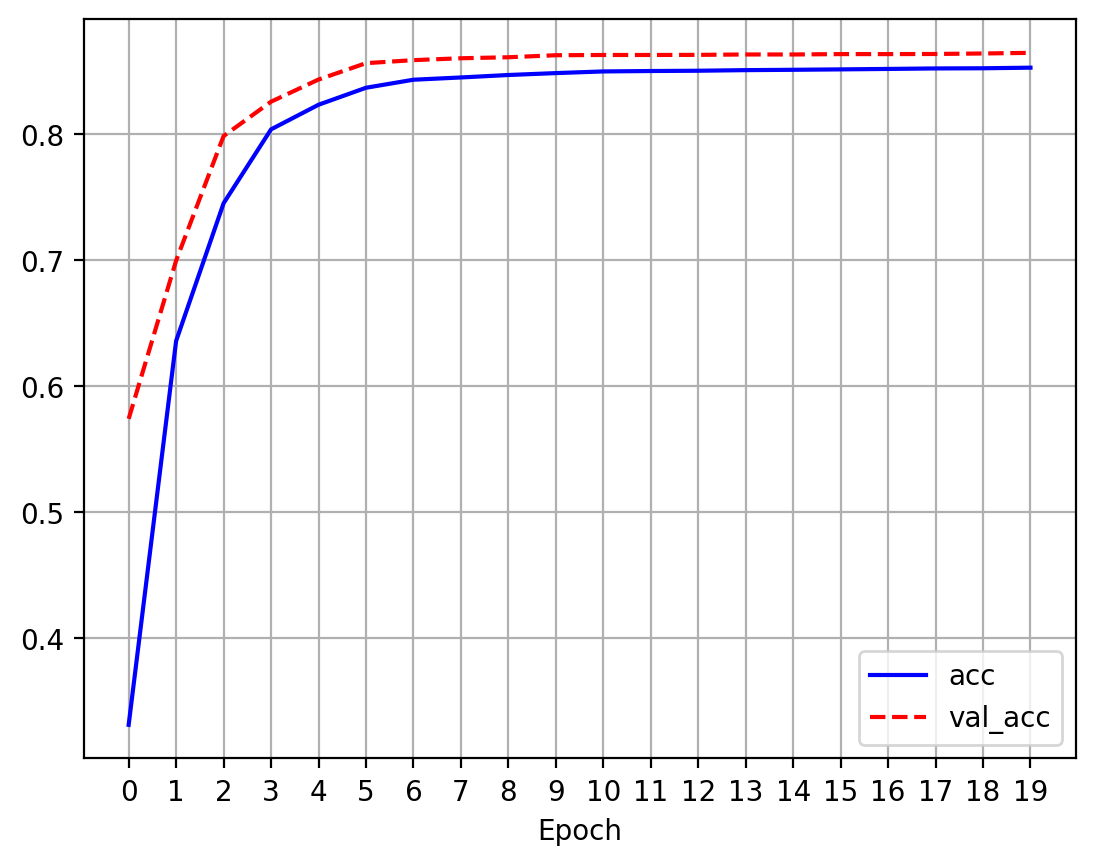

In [20]:
plt.plot(hist.history['accuracy'], 'b-', label='acc')
plt.plot(hist.history['val_accuracy'], 'r--', label='val_acc')
plt.xlabel('Epoch')
plt.xticks(range(20))
plt.grid()
plt.legend()
plt.show()

In [21]:
%load_ext tensorboard

In [22]:
new_model = build_lenet_5(input_shape=input_shape)
new_model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy']
                 )

In [23]:
new_model.evaluate(x_test,y_test)

 18/313 [>.............................] - ETA: 1s - loss: 2.3035 - accuracy: 0.0920

2023-06-20 15:30:25.355029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 2.3057 - accuracy: 0.0841


[2.3056986331939697, 0.08410000056028366]

In [40]:
log_dir = 'log'
filepath3 = os.path.join(save_dir, log_dir)

tensorboard_cb = keras.callbacks.TensorBoard(filepath3, histogram_freq=1)

In [25]:
new_model.fit(x_train, y_train,
              epochs=20,
              batch_size=32,
              validation_data=(x_test, y_test),
              callbacks=[tensorboard_cb]
             )

Epoch 1/20
   7/1875 [..............................] - ETA: 17s - loss: 2.3004 - accuracy: 0.0938 

2023-06-20 15:31:52.867648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 18s 9ms/step - loss: 0.6918 - accuracy: 0.8253 - val_loss: 0.3032 - val_accuracy: 0.9152
Epoch 2/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2677 - accuracy: 0.9222 - val_loss: 0.2161 - val_accuracy: 0.9345
Epoch 3/20
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1973 - accuracy: 0.9420 - val_loss: 0.1609 - val_accuracy: 0.9515
Epoch 4/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1521 - accuracy: 0.9546 - val_loss: 0.1274 - val_accuracy: 0.9631
Epoch 5/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1224 - accuracy: 0.9634 - val_loss: 0.1024 - val_accuracy: 0.9709
Epoch 6/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1022 - accuracy: 0.9701 - val_loss: 0.0897 - val_accuracy: 0.9736
Epoch 7/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0880 - accuracy: 0.9741 - val_loss: 0.0769 - val_accuracy: 0.

In [42]:
%tensorboard --logdir $filepath3

In [27]:
filepath4 = os.path.join(save_dir, 'save')
new_model.save(filepath4)

INFO:tensorflow:Assets written to: /Users/jaehwan/Desktop/Git/DeepLearning/CV/4. Classic_CNNs/LeNet/save/assets


INFO:tensorflow:Assets written to: /Users/jaehwan/Desktop/Git/DeepLearning/CV/4. Classic_CNNs/LeNet/save/assets


## Resizing CIFAR10 from [32, 32, 3] to [227,227,3]

In [75]:
cifar10 = keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train Labels: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test Labels: {dict(zip(unique, counts))}")

print(x_train.shape)

Train Labels: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Test Labels: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}
(50000, 32, 32, 3)


In [81]:
# Count the number of labels
num_labels = len(unique)

# One-Hot Encoding
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

# Normalize
x_train = x_train.astype('float32')/255 # Normalize
x_test = x_test.astype('float32')/255 # Normalize

## AlexNet_ImageNet

### Input Shape: 227x227x3(ImageNet)
**Convolution Layers**

1. ConV (11x11, s=4, activation='relu', filters=96, padding='valid')
2. MaxPool (f=3, s=2)
3. BatchNorm
4. ConV (5x5, s=1, activation='relu', filters=256, padding='same', regularizer='l2')
5. MaxPool (f=3, s=2, padding='valid')
6. BatchNorm
7. ConV (3x3, s=1, activation='relu', filters=384, pading='same', regularizer='l2')
8. BatchNorm
9. ConV (3x3, s=1, activation='relu', filters=384, pading='same', regularizer='l2')
10. BatchNorm
11. ConV (3x3, s=1, activation='relu', filters=256, pading='same', regularizer='l2')
12. BatchNorm
13. MaxPool (f=3, s=2, padding='valid')
14. Flatten

**Fully Connected Layers**

15. Dense(units=4096, activation='relu')
16. Dropout(0.5)
17. Dense(units=4096, activation='relu')
18. Dropout(0.5)

**Outputs**

19. Dense(units=1000, activation='softmax')

In [76]:
from models.AlexNet import build_alexnet

model = build_alexnet((227,227,3), num_classes=10)
model.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 27, 27, 96)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_31 (Ba  (None, 27, 27, 96)        384       
 tchNormalization)                                               
                                                                 
 conv2d_46 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 13, 13, 256)       0   

In [77]:
def func_resizing_model():
    inputs = keras.Input(shape = (32, 32, 3))
    resized = keras.layers.experimental.preprocessing.Resizing(227, 227,
                                                          interpolation="bilinear",
                                                          input_shape=input_shape)(inputs)
    outputs = model(resized)
    return keras.Model(inputs=inputs, outputs=outputs)
resizing_model = func_resizing_model()
resizing_model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 resizing_22 (Resizing)      (None, 227, 227, 3)       0         
                                                                 
 AlexNet (Functional)        (None, 10)                58327818  
                                                                 
Total params: 58327818 (222.50 MB)
Trainable params: 58325066 (222.49 MB)
Non-trainable params: 2752 (10.75 KB)
_________________________________________________________________


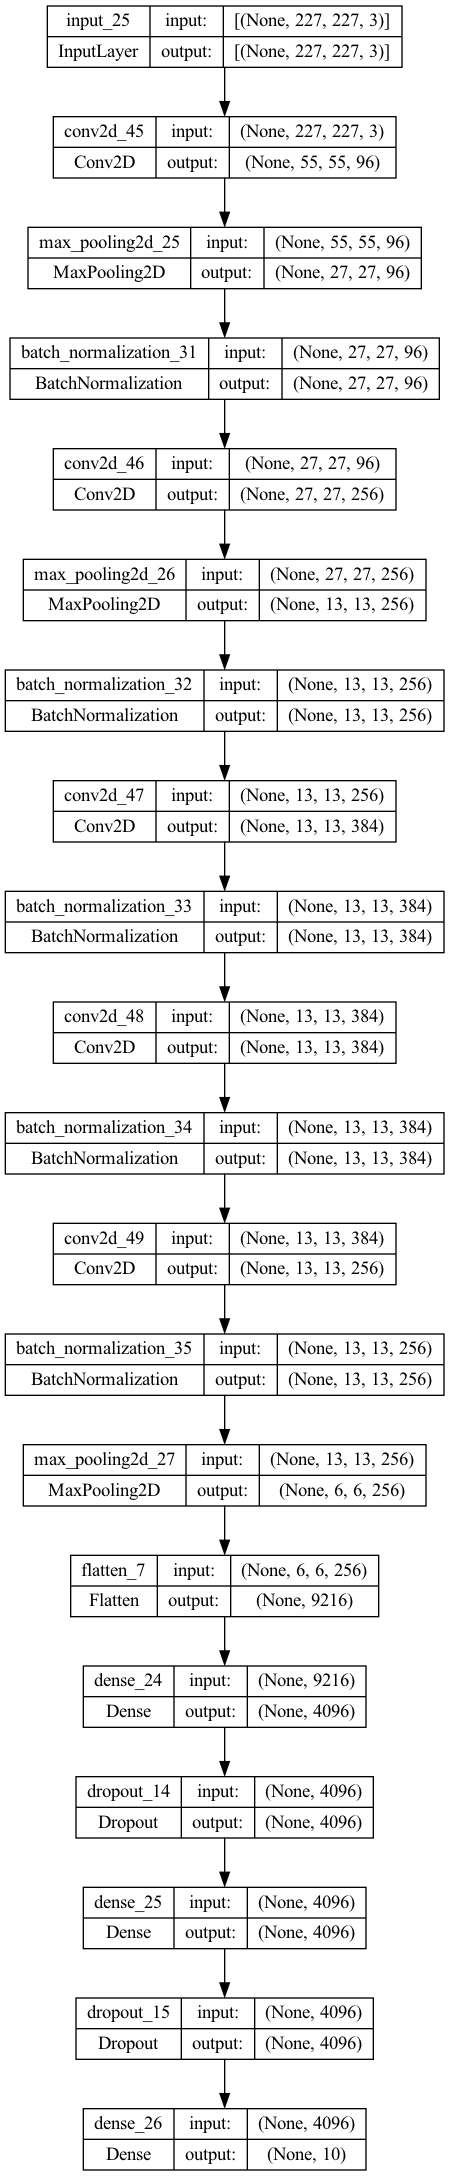

In [78]:
import os

save_dir = os.path.join(os.getcwd(), 'AlexNet')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

filepath1 = os.path.join(save_dir, 'ImageNet_AlexNet.png')

keras.utils.plot_model(model=model,
                       to_file=filepath1,
                       show_shapes=True
                      )

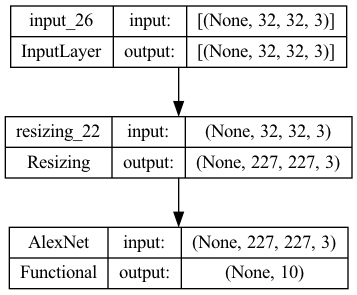

In [79]:
filepath2 = os.path.join(save_dir, 'Cifar10_AlexNet.png')

keras.utils.plot_model(model=resizing_model,
                       to_file=filepath2,
                       show_shapes=True
                      )

In [83]:
learning_rate=0.001
batch_size=512

resizing_model.compile(loss='categorical_crossentropy',
                       optimizer=keras.optimizers.legacy.Adam(learning_rate),
                       metrics=['accuracy']
                      )

history = resizing_model.fit(x_train, y_train,
                             epochs=10,
                             batch_size=batch_size,
                             validation_data=(x_test, y_test)
                            )

Epoch 1/10


2023-06-20 17:19:45.939590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68/98 [===================>..........] - ETA: 1:29 - loss: 419.0796 - accuracy: 0.1947

KeyboardInterrupt: 

## VGG16

### Input Shape: 227x227x3(ImageNet)
**Convolution Layers**

- ConV (k=3, s=1, f=64, a='relu', p='same')
- ConV (k=3, s=1, f=64, a='relu', p='same')
- MaxPool (p=2, s=2)

- ConV (k=3, s=1, f=128, a='relu', p='same')
- ConV (k=3, s=1, f=128, a='relu', p='same')
- MaxPool (p=2, s=2)

- ConV (k=3, s=1, f=256, a='relu', p='same')
- ConV (k=3, s=1, f=256, a='relu', p='same')
- ConV (k=3, s=1, f=256, a='relu', p='same')
- MaxPool (p=2, s=2)

- ConV (k=3, s=1, f=512, a='relu', p='same')
- ConV (k=3, s=1, f=512, a='relu', p='same')
- ConV (k=3, s=1, f=512, a='relu', p='same')
- MaxPool (p=2, s=2)

- ConV (k=3, s=1, f=512, a='relu', p='same')
- ConV (k=3, s=1, f=512, a='relu', p='same')
- ConV (k=3, s=1, f=512, a='relu', p='same')
- MaxPool (p=2, s=2)

**Fully Connected Layers**

- Flatten
- Dense(units=4096, activation='relu')
- Dropout(0.5)
- Dense(units=4096, activation='relu')
- Dropout(0.5)

**Outputs**

10. Dense(units=1000, activation='softmax')

In [9]:
from models.VGG16 import build_vgg16

model = build_vgg16((227, 227, 3))
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 227, 227, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 227, 227, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 113, 113, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 113, 113, 128)     73856     
                                                                 
 conv2d_8 (Conv2D)           (None, 113, 113, 128)     147584    
                                                             

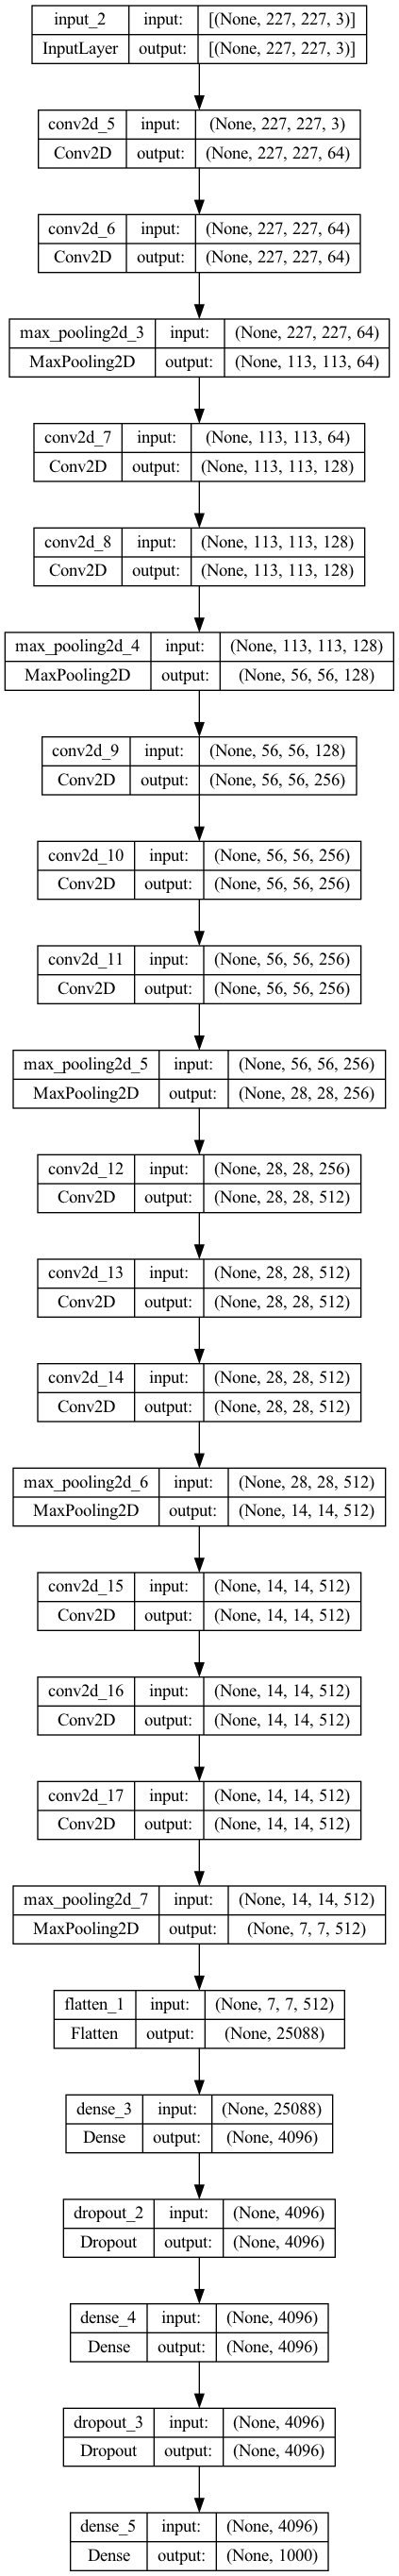

In [10]:
import os

save_dir = os.path.join(os.getcwd(), 'VGG16')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
filepath1 = os.path.join(save_dir, 'ImageNet_VGG16.png')

keras.utils.plot_model(model=model,
                       to_file=filepath1,
                       show_shapes=True
                      )

# MNIST
## Load Data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
from tensorflow import keras
import tensorflow as tf
from keras.datasets import cifar10, mnist
import numpy as np

(x_train, y_train),(x_test, y_test) = mnist.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train Labels: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test Labels: {dict(zip(unique, counts))}")

print(x_train.shape)

Train Labels: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test Labels: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
(60000, 28, 28)


In [20]:
x_train = tf.pad(x_train, [[0,0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)

x_test = tf.pad(x_test, [[0,0], [2,2], [2,2]])/255
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_test = tf.repeat(x_test, 3, axis=3)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)


x_val = x_train[-2000:, :, :, :]
y_val = y_train[-2000:]
x_train = x_train[:-2000, :, :, :]
y_train = y_train[:-2000]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)

(58000, 32, 32, 3)
(2000, 32, 32, 3)
(58000, 10)


# GoogleNet
## Inception Module
### bottleneck layer

In [5]:
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks')
os.getcwd()

'/content/drive/MyDrive/Colab_Notebooks'

In [6]:
from GoogLeNet import inception_module, build_GoogLeNet

In [7]:
input_shape = (32, 32, 3)
model = build_GoogLeNet(input_shape=input_shape)
model.summary()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv_1_7x7/2 (Conv2D)          (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pool_1_3x3/2 (MaxPooling2D  (None, 56, 56, 64)  0           ['conv_1_7x7/2[0][0]']   

In [8]:
import math
from keras.callbacks import LearningRateScheduler

epochs = 5 #25
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    # decay 4% every 8epoch
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_schedule = LearningRateScheduler(decay, verbose=1)
sgd = keras.optimizers.SGD(learning_rate=initial_lrate, momentum=0.9, nesterov=False)

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy']
             )

hist = model.fit(x_train, y_train, batch_size=256, epochs=epochs,
                 validation_data=(x_val, y_val), callbacks=[lr_schedule], verbose=2,
                 shuffle=True
                )


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/5
227/227 - 233s - loss: 0.8783 - accuracy: 0.6921 - val_loss: 0.6555 - val_accuracy: 0.8475 - lr: 0.0100 - 233s/epoch - 1s/step

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/5
227/227 - 194s - loss: 0.1138 - accuracy: 0.9656 - val_loss: 0.0649 - val_accuracy: 0.9835 - lr: 0.0100 - 194s/epoch - 853ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/5
227/227 - 193s - loss: 0.0734 - accuracy: 0.9772 - val_loss: 0.0388 - val_accuracy: 0.9880 - lr: 0.0100 - 193s/epoch - 851ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/5
227/227 - 194s - loss: 0.0585 - accuracy: 0.9818 - val_loss: 0.0284 - val_accuracy: 0.9925 - lr: 0.0100 - 194s/epoch - 853ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/5
227/227 - 194s - loss: 0.0431 - accuracy: 0.9867 - val_loss: 0.0233 - val_accuracy: 0.9945 - lr: 0.0100 - 194s/epoch -

# ResNet

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [16]:
from ResNet import bottleneck_residual_block, ResNet50
from tensorflow import keras

In [14]:
model = ResNet50(input_shape=(32,32,3), classes=10)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 13, 13, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 13, 13, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 activation_49 (Activation)     (None, 13, 13, 64)   0           ['bn_conv1[0][0]']               
                                                                                           

 ormalization)                                                                                    
                                                                                                  
 add_18 (Add)                   (None, 6, 6, 256)    0           ['batch_normalization_61[0][0]', 
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 6, 6, 256)    0           ['add_18[0][0]']                 
                                                                                                  
 conv2d_63 (Conv2D)             (None, 3, 3, 128)    32896       ['activation_58[0][0]']          
                                                                                                  
 batch_normalization_63 (BatchN  (None, 3, 3, 128)   512         ['conv2d_63[0][0]']              
 ormalizat

                                                                                                  
 conv2d_72 (Conv2D)             (None, 3, 3, 128)    65664       ['activation_67[0][0]']          
                                                                                                  
 batch_normalization_72 (BatchN  (None, 3, 3, 128)   512         ['conv2d_72[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_68 (Activation)     (None, 3, 3, 128)    0           ['batch_normalization_72[0][0]'] 
                                                                                                  
 conv2d_73 (Conv2D)             (None, 3, 3, 128)    147584      ['activation_68[0][0]']          
                                                                                                  
 batch_nor

 activation_77 (Activation)     (None, 2, 2, 256)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 conv2d_83 (Conv2D)             (None, 2, 2, 256)    590080      ['activation_77[0][0]']          
                                                                                                  
 batch_normalization_83 (BatchN  (None, 2, 2, 256)   1024        ['conv2d_83[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 2, 2, 256)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 conv2d_84 (Conv2D)             (None, 2, 2, 1024)   263168      ['activation_78[0][0]']          
          

 batch_normalization_93 (BatchN  (None, 2, 2, 1024)  4096        ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_28 (Add)                   (None, 2, 2, 1024)   0           ['batch_normalization_93[0][0]', 
                                                                  'activation_85[0][0]']          
                                                                                                  
 activation_88 (Activation)     (None, 2, 2, 1024)   0           ['add_28[0][0]']                 
                                                                                                  
 conv2d_95 (Conv2D)             (None, 1, 1, 512)    524800      ['activation_88[0][0]']          
                                                                                                  
 batch_nor

 activation_97 (Activation)     (None, 1, 1, 2048)   0           ['add_31[0][0]']                 
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, 1, 1, 2048)  0           ['activation_97[0][0]']          
 oling2D)                                                                                         
                                                                                                  
 flatten_1 (Flatten)            (None, 2048)         0           ['average_pooling2d_1[0][0]']    
                                                                                                  
 fc10 (Dense)                   (None, 10)           20490       ['flatten_1[0][0]']              
                                                                                                  
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
__________________________

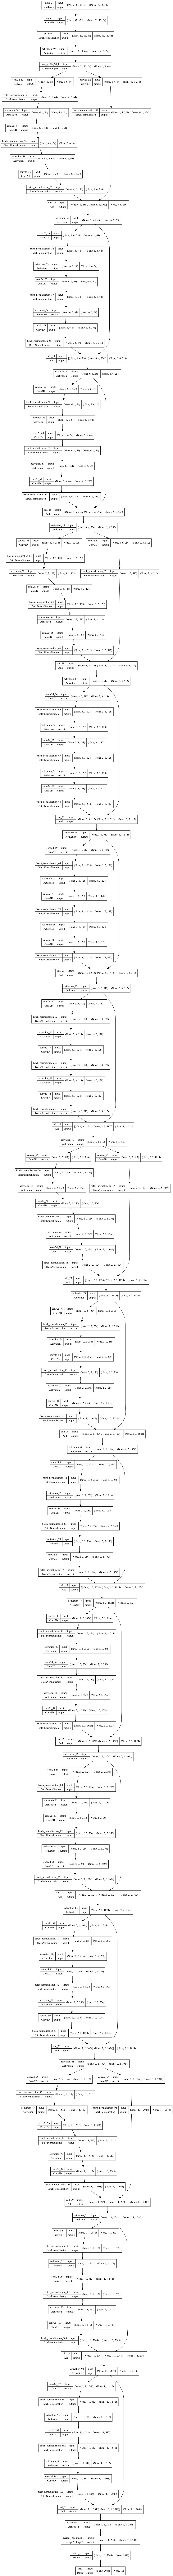

In [17]:
import os

save_dir = os.path.join(os.getcwd(), 'ResNet')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
filepath1 = os.path.join(save_dir, 'ResNet50.png')
keras.utils.plot_model(model=model,
                       to_file=filepath1,
                       show_shapes=True
                      )

In [21]:
from keras.callbacks import ReduceLROnPlateau
import numpy as np

epochs = 5 #200
batch_size = 256

reduce_lr = ReduceLROnPlateau(modnitor='val_loss',
                              factor=np.sqrt(0.1),
                              patience=5,
                              min_lr=0.5e-6
                             )

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy']
             )

model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_val, y_val),
          epochs=epochs, callbacks=[reduce_lr]
         )

Epoch 1/5


2023-03-19 15:23:42.040729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


227/227 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.8638

2023-03-19 15:25:07.252085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


227/227 [==============================] - 90s 377ms/step - loss: 0.4748 - accuracy: 0.8638 - val_loss: 1.7932 - val_accuracy: 0.3370 - lr: 0.0100
Epoch 2/5
227/227 [==============================] - 84s 369ms/step - loss: 0.0979 - accuracy: 0.9693 - val_loss: 0.0808 - val_accuracy: 0.9790 - lr: 0.0100
Epoch 3/5
227/227 [==============================] - 84s 368ms/step - loss: 0.0464 - accuracy: 0.9855 - val_loss: 0.0793 - val_accuracy: 0.9790 - lr: 0.0100
Epoch 4/5
227/227 [==============================] - 85s 375ms/step - loss: 0.0218 - accuracy: 0.9932 - val_loss: 0.0694 - val_accuracy: 0.9810 - lr: 0.0100
Epoch 5/5
227/227 [==============================] - 99s 434ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.0718 - val_accuracy: 0.9820 - lr: 0.0100
